<a href="https://colab.research.google.com/github/Nancy-Shi/ICE_Manuscript/blob/main/110223_Compare_Hypergraph_Big_gamma_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code is used to demonstrate the result of hypergraph rumor spread on a network. In this example, the network size is 400, with degree exponent of 2.5, and minimum degree of 3. The number of hyperedges (groups) is set to 100. The heatmap shows the stifler density with varying transmission rate while setting the threshold constant to 0.

In [1]:
#!pip install hypernetx
import hypernetx as hnx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log
import seaborn as sns
import pandas as pd

 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


## Part 1: Hypergraph Generation
The following steps generate a hyper graph using the XGI/HyperNetX python package,  following power-law degree distribution for predifined number of nodes n, number of hyperedges num_hyper_edges, degree exponent gamma, using a configuration model with data stored in a dictionary.

In [2]:
# Step 1: Generate Degree Sequence
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    # kmax = int(1.5*n**(1/4)) # max degree allowed is 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

# Step 2: Generate Hyper Edge Size Sequence
def generate_hyper_edge_sizes(degrees, num_hyper_edges):
    total_degrees = sum(degrees)
    hyper_edge_sizes = []

    # Calculate the average size for each hyper edge
    avg_size = total_degrees // num_hyper_edges
    remainder = total_degrees % num_hyper_edges

    # Define the range for the random distribution
    min_size = 1  # Lower bound of the range
    max_size = len(degrees)-num_hyper_edges  # Upper bound of the range

    # Generate hyper edge sizes
    for _ in range(num_hyper_edges):
        size = random.randint(min_size, max_size)
        hyper_edge_sizes.append(size)

    return hyper_edge_sizes


# Step 3: Create Copies of Nodes
def create_node_copies(degrees):
    node_copies = []
    for i, degree in enumerate(degrees):
        for _ in range(degree):
            node_copies.append(i)
    return node_copies

# Step 4: Create Copies of Hyper Edges
def create_hyper_edge_copies(hyper_edge_sizes):
    hyper_edge_copies = []
    for i, size in enumerate(hyper_edge_sizes):
        for _ in range(size):
            hyper_edge_copies.append(i)
    return hyper_edge_copies

# Step 5: Randomly Pair Copies
def randomly_pair_copies(node_copies, hyper_edge_copies):
    random.shuffle(node_copies)
    random.shuffle(hyper_edge_copies)
    pairs = []
    for i in range(len(node_copies)):
        pairs.append((node_copies[i], hyper_edge_copies[i]))
    return pairs

# Step 6: Convert Bipartite Graph to A Hypergraph Dictionary
def convert_to_hypergraph(pairs):
    hypergraph = {}
    for pair in pairs:
        node, hyper_edge = pair
        if hyper_edge in hypergraph:
            hypergraph[hyper_edge].append(node)
        else:
            hypergraph[hyper_edge] = [node]
    return hypergraph


In [3]:
def build_hypergraph(n, gamma, kmin, num_hyper_edges):
    # Step 1: Generate Degree Sequence
    degrees = generate_degree_sequence(n, gamma, kmin)
    print("Degree Sequence: ", degrees)

    # Step 2: Generate Hyper Edge Size Sequence
    hyper_edge_sizes = generate_hyper_edge_sizes(degrees, num_hyper_edges)
    print("Hyper Edge Sizes: ", hyper_edge_sizes)

    # Step 3: Create Copies of Nodes
    node_copies = create_node_copies(degrees)

    # Step 4: Create Copies of Hyper Edges
    hyper_edge_copies = create_hyper_edge_copies(hyper_edge_sizes)

    # Step 5: Randomly Pair Copies
    pairs = randomly_pair_copies(node_copies, hyper_edge_copies)

    # Step 6: Convert Bipartite Graph to Hypergraph
    hyperedge_dict = convert_to_hypergraph(pairs)

    # Print the resulting hypergraph
    print("Hypergraph Dictionary: ", hyperedge_dict)

    return degrees, hyperedge_dict


In [4]:
# Test 1
n =50  # Number of nodes
gamma = 2.5  # Power-law exponent
kmin = 3  # Minimum degree
num_hyper_edges = 8  # Desired number of hyper edges

degrees, hyperedge_dict = build_hypergraph(n, gamma, kmin, num_hyper_edges)

Degree Sequence:  [3, 3, 4, 3, 4, 6, 4, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Hyper Edge Sizes:  [11, 36, 40, 19, 8, 30, 19, 12]
Hypergraph Dictionary:  {5: [12, 31, 35, 41, 26, 27, 28, 35, 33, 45, 43, 1, 30, 49, 43, 30, 13, 34, 46, 0, 5, 14, 11, 44, 15, 31, 32, 2, 6, 16], 6: [29, 44, 30, 48, 28, 35, 42, 25, 5, 15, 23, 28, 47, 10, 9, 13], 7: [20, 7, 17, 43, 24, 20, 21, 17, 48, 2, 12, 26], 2: [39, 38, 18, 33, 22, 5, 47, 27, 29, 40, 34, 16, 13, 45, 7, 1, 8, 15, 4, 10, 31, 5, 4, 23, 7, 26, 21, 22, 19, 11, 20, 36, 19, 5, 22, 19], 1: [8, 25, 42, 3, 6, 39, 1, 41, 23, 18, 25, 29, 0, 17, 45, 27, 38, 11, 46, 16, 41, 8, 9, 0, 24, 36, 40, 38, 3, 3, 49], 3: [39, 10, 18, 7, 14, 32, 12, 49, 40, 37, 44, 42, 37, 46, 36, 47], 0: [14, 24, 7, 9, 4, 32, 33, 6, 2, 34], 4: [37, 48, 2, 5, 6, 21, 4]}


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(typ

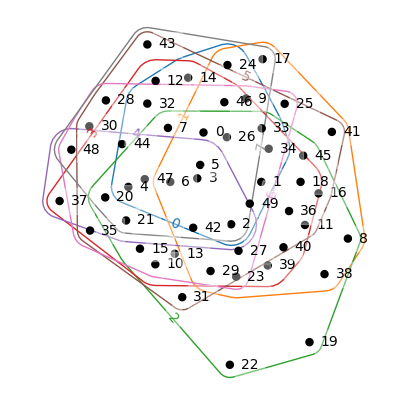

In [5]:
# Plot the hypergraph
H = hnx.Hypergraph(hyperedge_dict)
plt.subplots(figsize=(5,5))
hnx.draw(H)

In [6]:
# Test 2
n2 =400  # Number of nodes
gamma2 = 2.5  # Power-law exponent
kmin2 = 3  # Minimum degree
num_hyper_edges2 = 100  # Desired number of hyper edges

degrees2, hyperedge_dict2 = build_hypergraph(n2, gamma2, kmin2, num_hyper_edges2)
H2 = hnx.Hypergraph(hyperedge_dict2)

Degree Sequence:  [3, 5, 11, 4, 6, 3, 3, 3, 3, 13, 3, 5, 3, 6, 5, 3, 7, 3, 5, 4, 4, 13, 3, 3, 3, 4, 5, 8, 3, 3, 3, 6, 14, 3, 3, 3, 4, 7, 20, 4, 3, 3, 3, 3, 4, 3, 3, 3, 6, 3, 3, 4, 3, 3, 4, 4, 6, 7, 4, 4, 4, 4, 5, 3, 3, 4, 6, 4, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 5, 4, 4, 8, 4, 3, 3, 3, 6, 3, 9, 3, 6, 3, 3, 4, 12, 3, 3, 5, 5, 4, 4, 5, 4, 3, 3, 4, 8, 8, 4, 3, 6, 4, 6, 3, 16, 3, 7, 6, 3, 3, 3, 8, 4, 7, 9, 7, 5, 4, 3, 3, 4, 20, 5, 3, 16, 3, 5, 3, 5, 3, 3, 20, 3, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [7]:
# Test 3
n3 =400  # Number of nodes
gamma3 = 2.5  # Power-law exponent
kmin3 = 3  # Minimum degree
num_hyper_edges3 = 100  # Desired number of hyper edges

degrees3, hyperedge_dict3 = build_hypergraph(n3, gamma3, kmin3, num_hyper_edges3)
H3 = hnx.Hypergraph(hyperedge_dict3)

Degree Sequence:  [3, 13, 9, 3, 3, 3, 10, 3, 3, 3, 5, 6, 8, 3, 4, 3, 3, 4, 3, 4, 8, 4, 3, 7, 7, 3, 4, 3, 3, 3, 3, 3, 3, 7, 3, 3, 4, 5, 3, 3, 4, 3, 3, 5, 7, 3, 6, 5, 3, 4, 3, 3, 3, 12, 9, 3, 3, 4, 14, 11, 3, 3, 3, 4, 3, 5, 3, 19, 4, 5, 3, 3, 3, 14, 3, 3, 3, 3, 3, 3, 4, 6, 10, 3, 4, 4, 4, 4, 3, 5, 4, 4, 3, 3, 3, 4, 3, 7, 10, 3, 4, 4, 5, 3, 3, 3, 5, 3, 3, 6, 3, 4, 6, 5, 3, 7, 5, 4, 4, 8, 3, 3, 5, 19, 3, 4, 3, 4, 4, 3, 3, 7, 3, 5, 4, 4, 5, 4, 3, 3, 4, 6, 3, 5, 3, 4, 4, 3, 3, 3, 17, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


## Part 2: Assign Threshold
The following steps assigns a threshold value to each node in the network. The threshold follows a uniform or normal distribution with predefined mean (mu) and standard deviation (sigma).

In [8]:
import numpy as np
import random

# Defines the parameters to be used
mu = 0.1
sigma = 0.05

# Function to assign thresholds to the individual nodes
def assign_thresholds(hypergraph):
    NV = hypergraph.order()
    Ltre = {}

    for node in hypergraph.nodes():
          # Uniform distribution: #
          #Ltre[node] = np.random.uniform()
          # Normal distrution
          while True:
              threshold = random.gauss(mu, sigma)
              if 0 < threshold < 1:
                  break
          Ltre[node] = threshold

    return Ltre

Ltre = assign_thresholds(H)

print("Threshold List for Nodes: ", Ltre )

Threshold List for Nodes:  {0: 0.1521813081674831, 1: 0.10571908847138613, 2: 0.1277329843386284, 3: 0.1806250120373432, 4: 0.11725500217824056, 5: 0.1583669847596708, 6: 0.13473254406556337, 7: 0.020815642551806374, 8: 0.1316480234000874, 9: 0.17232928806444492, 10: 0.13986604512945183, 11: 0.09244091746898682, 12: 0.13129982793127254, 13: 0.09078008609563347, 14: 0.0766434777280702, 15: 0.1695783857526088, 16: 0.07312548132952097, 17: 0.06634359011142071, 18: 0.1344071825092143, 19: 0.05258374739817994, 20: 0.006721322441729238, 21: 0.20095335510439138, 22: 0.10247112832728734, 23: 0.1216516714306812, 24: 0.08307005775150314, 25: 0.19480954573124354, 26: 0.11571123739446319, 27: 0.13482138983722297, 28: 0.0997265534819462, 29: 0.10171403691092781, 30: 0.19778519605714187, 31: 0.005759406368614495, 32: 0.04249615969826115, 33: 0.12675945003594305, 34: 0.030705374731474055, 35: 0.10378666178016537, 36: 0.047286652147113445, 37: 0.060163278795433095, 38: 0.0953980133921672, 39: 0.090239

In [9]:
Ltre2 = assign_thresholds(H2)

print("Threshold List for Nodes: ", Ltre2 )

Threshold List for Nodes:  {0: 0.09647583156220894, 1: 0.05035899131214852, 2: 0.17402735271619502, 3: 0.005861440892971137, 4: 0.039762858642436075, 5: 0.07900822545689117, 6: 0.023969684958381893, 7: 0.14262231970665631, 8: 0.15034842916209193, 9: 0.04996295806706853, 10: 0.07122408862301563, 11: 0.0682212573710401, 12: 0.07322995468660586, 13: 0.07196061979495788, 14: 0.09724153942349646, 15: 0.16751294297182576, 16: 0.027829093319211726, 17: 0.1342570842425685, 18: 0.20348418678920918, 19: 0.05727338378593204, 20: 0.058547083957577455, 21: 0.12251524052952613, 22: 0.09594451093803862, 23: 0.11532245629257903, 24: 0.10600607839499968, 25: 0.12128175698922722, 26: 0.17721192596662352, 27: 0.08450705041610088, 28: 0.1316014594119825, 29: 0.1369046954286523, 30: 0.12607330409921133, 31: 0.10770847861917529, 32: 0.07642482013617058, 33: 0.06258463821246496, 34: 0.04188107293535447, 35: 0.08787945053282559, 36: 0.069558052854715, 37: 0.06260186811132509, 38: 0.06161013104140202, 39: 0.07

## Part 3: Rumor Spreading on Hypergraph
The follow steps extends the basic rumor spreading model to a hypergraph. An infection or recovery event can only happen if its infected or recovered neighbors reach a pre-assigned threshold.  

In [10]:
def rumor_hyperedge_3(nw, ldeg, mu, lam, alp, n_samp):
    t_max = 10000
    N = nw.order()
    kmax = max(ldeg)
    sigma = 0
    ltre = assign_thresholds(nw)

    t_end = 0
    stifler_fractions = []

    for i_samp in range(1, n_samp+1):
        t = 0
        N_rec = 0

        states = {j: 0 for j in nw.nodes()}

        inf = []
        rec = []
        initial_node = np.random.choice(list(nw.nodes()))
        states[initial_node] = 1
        inf.append(initial_node)
        N_inf = 1
        N_e = nw.degree(initial_node)

        while N_inf != 0:
            total_rate = lam * N_e + 2 * alp * N_e
            tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
            t += tau

            if t >= t_max or lam == 0:
                break

            #print("Current time:", t)
            #print("Infected nodes:", inf)
            #print("Recovered nodes:", rec)
            #print("N_inf:", N_inf)
            #print("N_e:", N_e)
            #plt.figure()
            #plot_hypergraph(H, states)

            # Determine which event occurs
            event = np.random.uniform()
            p1 = lam / (lam + 2 * alp)
            p2 = (lam + alp )/ (lam + 2 * alp)

            # Determine if accept selected spreader based on degree distribution
            q_deg = np.random.uniform()


            # Infection:
            if event <= p1:
                # Select a spreader individual to spread the rumor
                inf_node = random.choice(inf)
                if q_deg < ldeg[inf_node] / kmax:
                    # Select a random hyper edge containing the infected node
                    infected_hyper_edge = np.random.choice(list(nw.edges()))
                    neighbors = nw[infected_hyper_edge]
                    while inf_node not in neighbors:
                        infected_hyper_edge = np.random.choice(list(nw.edges()))
                        neighbors = nw[infected_hyper_edge]

                    # Check if any neighbor meets the infection threshold
                    for neighbor in neighbors:
                        # Check if the selected neighbor is ignorant
                            if states[neighbor] == 0:
                                #print("Infection event")
                            # Check the threshold
                                count_inf_neighbors = sum(states[node] == 1 for node in nw.neighbors(neighbor))
                                if count_inf_neighbors / len(nw.neighbors(neighbor)) >= ltre[neighbor]:
                                    states[neighbor] = 1  # ignorant neighbor becomes spreader
                                    inf.append(neighbor)
                                    N_inf += 1
                                    #print("successful infection")


            else:  # Recovery
                # Select a spreader individual to recover
                rec_node = np.random.choice(inf)
                if q_deg < ldeg[rec_node] / kmax:
                    # Select a random hyperedge containing the recovered node
                    recovered_hyper_edge = np.random.choice(list(nw.edges()))
                    # Get neighbors list
                    neighbors = nw[recovered_hyper_edge]
                    #print("Recovery event", neighbors)
                    if event <=p2:
                        count_rec_neighbors = sum(states[node] == 2 for node in neighbors)
                        #print("count_rec_neighbors", count_rec_neighbors)
                        if count_rec_neighbors / len(neighbors) >= ltre[rec_node]:
                        #if count_rec_neighbors > 0:
                            # Update spreader to stifler if the selected neighbor is a stifler or spreader
                            states[rec_node] = 2
                            N_inf -= 1
                            inf.remove(rec_node)
                            rec.append(rec_node)
                            N_rec += 1
                            #print("successful recovery")

                    else:
                        count_rec_neighbors = sum(states[node] == 1 for node in neighbors)
                        #print("count_rec_neighbors", count_rec_neighbors)
                        if count_rec_neighbors / len(neighbors) >= ltre[rec_node]:
                        #if count_rec_neighbors > 0:
                            # Update spreader to stifler if the selected neighbor is a stifler or spreader
                            states[rec_node] = 2
                            N_inf -= 1
                            inf.remove(rec_node)
                            rec.append(rec_node)
                            N_rec += 1
                            #print("successful recovery")

            #print("N_inf after event:", N_inf)
            #print("N_e after event:", N_e)


        if N_inf == 0:
              t_end += t
              stifler_frac = N_rec / N
              stifler_fractions.append(stifler_frac)
              print("Sampling result - Lam:", lam, "N_rec:", N_rec, "t_end:", t_end, "stifler_frac:", stifler_frac)

        if lam == 0:
            t_end = 0
            stifler_frac = 0
            stifler_fractions.append(stifler_frac)
            print("Sampling result - Lam:", lam, "N_rec:", N_rec, "t_end:", t_end, "stifler_frac:", stifler_frac)


    avg_stifler_frac = sum(stifler_fractions) / len(stifler_fractions)
    t_end_av = t_end/n_samp

    #return nw, states
    return avg_stifler_frac, t_end_av

The following function generates the hypergraph based on nodes' disease status, where susceptible nodes are yellow, infected nodes are purple, and recovered nodes are green.

In [11]:
def plot_hypergraph(hypergraph, states):
    pos = nx.spring_layout(hypergraph)
    node_colors = []
    #node_sizes = []
    for node in hypergraph.nodes():
        if states[node] == 1:  # Infected node (purple)
            node_colors.append("purple")
        elif states[node] == 2:  # Recovered node (green)
            node_colors.append("green")
        else:  # Susceptible node (yellow)
            node_colors.append("yellow")
        #node_sizes.append(thresholds[node] * 100)  # Adjust node size based on threshold value

    hnx.drawing.draw(hypergraph, pos, nodes_kwargs={'facecolors': node_colors})

In [12]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:
n_samp = 500
alp = 1

# Set the mu and lambda_values
mu_values = np.arange(0.0, 0.1, 0.1)
lambda_values = np.arange(0.0, 3.0, 0.3)

# Initialize the result array
results = np.zeros((len(mu_values), len(lambda_values)))

# Iterate over mu and lambda values
for i, mu in enumerate(mu_values):
    for j, lam in enumerate(lambda_values):
        rho_R_av, t_end_av = rumor_hyperedge_3(H2, degrees2, mu, lam, alp, n_samp)
        results[i, j] = rho_R_av

df = pd.DataFrame(results)
df.to_csv('/content/drive/My Drive/Network_Tests/hyperedge_big_new_lambda_range.csv')



Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0

In [ ]:
# Set the mu and lambda_values
mu_values = np.arange(0.1, 0.2, 0.1)
lambda_values = np.arange(0.0, 3.0, 0.3)

# Initialize the result array
results = np.zeros((len(mu_values), len(lambda_values)))

# Iterate over mu and lambda values
for i, mu in enumerate(mu_values):
    for j, lam in enumerate(lambda_values):
        rho_R_av, t_end_av = rumor_hyperedge_3(H2, degrees2, mu, lam, alp, n_samp)
        results[i, j] = rho_R_av

df = pd.DataFrame(results)
df.to_csv('/content/drive/My Drive/Network_Tests/hyperedge_2_big_new_lambda_range.csv')



Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0.0 N_rec: 0 t_end: 0 stifler_frac: 0
Sampling result - Lam: 0

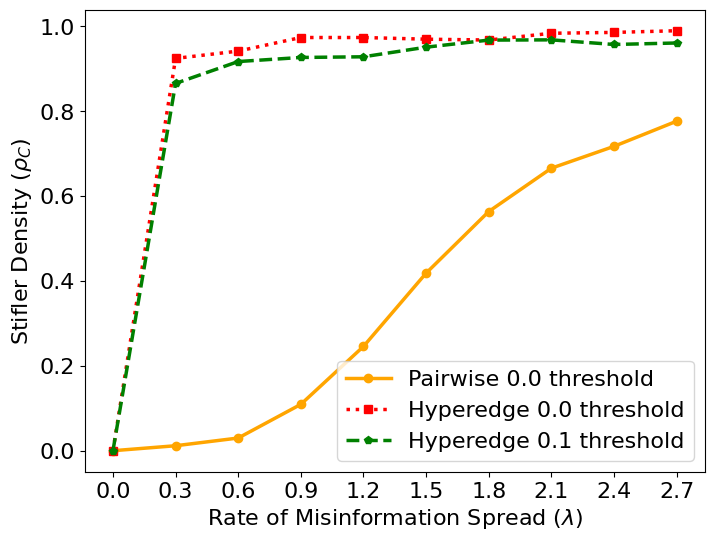

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
df1 = pd.read_csv('/content/drive/My Drive/Network_Tests/pairwise_big_new_lambda_range.csv', header=None)
df2 = pd.read_csv('/content/drive/My Drive/Network_Tests/hyperedge_big_new_lambda_range.csv', header=None)
df3 = pd.read_csv('/content/drive/My Drive/Network_Tests/hyperedge_2_big_new_lambda_range.csv', header=None)

# Get the second row from each dataframe
data1 = df1.iloc[1].values[1:]  # skip the first column assuming it's non-numeric
data2 = df2.iloc[1].values[1:]  # skip the first column assuming it's non-numeric
data3 = df3.iloc[1].values[1:]  # skip the first column assuming it's non-numeric

# Define the index values
#x = [i/10 for i in range(1, 10)]
x = np.arange(0.0, 3.0, 0.3)

fig, ax = plt.subplots(figsize=(8,6))

# Plot the curves
plt.plot(x, data1, label='Pairwise 0.0 threshold',  marker='o', color = "orange",linestyle = "-", linewidth=2.5)
plt.plot(x, data2, label='Hyperedge 0.0 threshold',  marker='s', color = "red",linestyle = ":", linewidth=2.5)
plt.plot(x, data3, label='Hyperedge 0.1 threshold', marker='p', color = "green",linestyle = "--", linewidth=2.5)

# Add title, labels, legend, and grid
# plt.title('Misinformation Spread in \n Pairwise vs Hyperedge Networks ($\gamma = 2.5$)', fontsize=16)
plt.xlabel(r'Rate of Misinformation Spread ($\lambda$)', fontsize=16)
plt.ylabel(r'Stifler Density ($\rho_C$)', fontsize=16)
plt.legend(loc=4, fontsize=16)

ax.set_xticks(np.arange(0.0, 3.0, 0.3))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Show the plot
plt.savefig('/content/drive/My Drive/Network_Tests/hyperedge_versus_pairwise_gamma_2.5_new_lambda_range.pdf')
plt.show()
